## IR

#### Importing Libraries


In [194]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
from torchvision import transforms, models
from transformers import BertTokenizer, BertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr,pearsonr
import os
#setting seeds
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

#### loading and displaying dataset

In [195]:
# Define paths for training and testing datasets
# These paths should be updated according to your directory structure
# The paths below are examples and should be replaced with actual paths on your system
train_img_path = "/home/lovish/PROJECTS/RealnessProject/Images/train_images"
train_csv_path = "/home/lovish/PROJECTS/RealnessProject/IRWD2/TrainGPT4_1.csv"

test_img_path = "/home/lovish/PROJECTS/RealnessProject/Images/test_images"
test_csv_path = "/home/lovish/PROJECTS/RealnessProject/IRWD2/TestGPT4_1.csv"

In [196]:
train_df=pd.read_csv(train_csv_path)
test_df=pd.read_csv(test_csv_path)
train_df, val_df = train_test_split(train_df, test_size=0.20, random_state=42)  
train_df.shape ,val_df.shape, test_df.shape

((408, 3), (102, 3), (90, 3))

#### Creating Dataset

In [197]:
class RealismDataset(torch.utils.data.Dataset):
    def __init__(self, df, image_dir, tokenizer, transform):
        self.df = df
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = f"{self.image_dir}/{row['filename']}"
        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        text = row['description']
        #text=" "
        inputs = self.tokenizer(text, padding='max_length', truncation=True, return_tensors="pt", max_length=128)

        
        #image*=0

        mos = torch.tensor(row['MOS'], dtype=torch.float)

        return image, inputs['input_ids'].squeeze(0), inputs['attention_mask'].squeeze(0), mos


#### Model Architecture
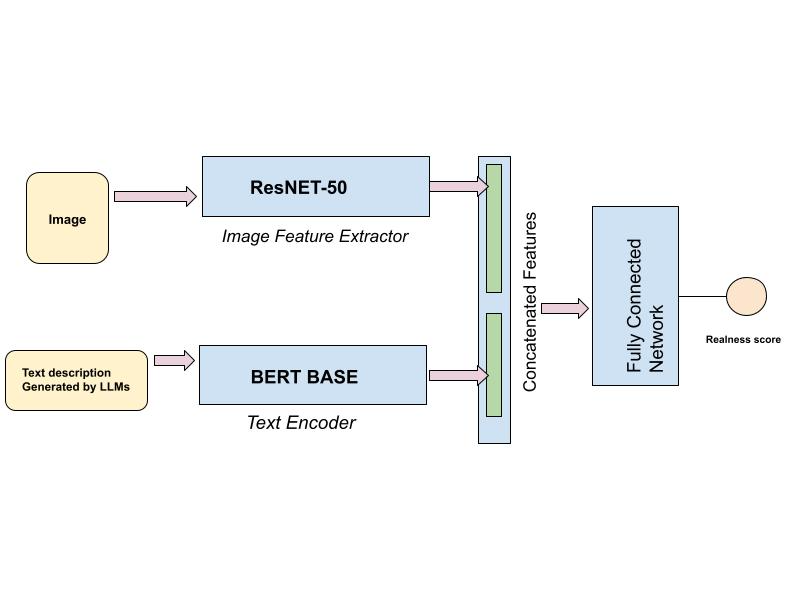


In [198]:
class MOSPredictor(nn.Module):
    def __init__(self,x=529,freeze_cnn=False, freeze_bert=False):
        super(MOSPredictor, self).__init__()
        # ResNet-50
        self.cnn = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        self.cnn.fc = nn.Identity()  # remove classification head


        # BERT
        self.bert = BertModel.from_pretrained('bert-base-uncased')
   

        # Fusion + Regression
        self.fc = nn.Sequential(
            nn.Linear(2048 + 768, x),
            nn.ReLU(),
            nn.Linear(x, 1)
        )

        # Optional Freezing
        if freeze_cnn:
            for param in self.cnn.parameters():
                param.requires_grad = False

        if freeze_bert:
            for param in self.bert.parameters():
                param.requires_grad = False

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.cnn(image)  # (B, 2048)
        text_feat = self.bert(input_ids=input_ids, attention_mask=attention_mask).pooler_output  # (B, 768)
        combined = torch.cat((img_feat, text_feat), dim=1)  # (B, 2816)
        output = self.fc(combined)  # (B, 1)
        return output.squeeze(1)  # (B,)


#### Helper Functions

In [199]:
from scipy.stats import spearmanr,pearsonr
@torch.no_grad()
def evaluate_spearman(model, test_loader, device):
    model.eval()
    all_preds = []
    all_targets = []

    for images, input_ids, attention_mask, mos in test_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        mos = mos.to(device)

        preds = model(images, input_ids, attention_mask)
        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(mos.cpu().numpy())

    corr, _ = spearmanr(all_targets, all_preds)
    pearsonr_corr, _ = pearsonr(all_targets, all_preds)
    return corr, pearsonr_corr

In [200]:
@torch.no_grad()
def validate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    for images, input_ids, attention_mask, mos in val_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        mos = mos.to(device)

        preds = model(images, input_ids, attention_mask)
        loss = criterion(preds, mos)
        total_loss += loss.item()
    return total_loss / len(val_loader)


In [201]:
def plot_losses(train_losses, val_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss", marker='o')
    plt.plot(val_losses, label="Validation Loss", marker='x')
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [202]:
transform = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomHorizontalFlip(),  # Data augmentation
    transforms.RandomRotation(10),  # Data augmentation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Data augmentation
])
transform_test = transforms.Compose([
    transforms.Resize((384, 512)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# dataset and dataloader
train_dataset = RealismDataset(train_df, image_dir=train_img_path, tokenizer=tokenizer, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

#validation dataset and dataloader
val_dataset = RealismDataset(val_df, image_dir=train_img_path, tokenizer=tokenizer, transform=transform)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)

# test dataset and dataloader
test_dataset = RealismDataset(test_df, image_dir=test_img_path, tokenizer=tokenizer, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

In [203]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [147]:
import matplotlib.pyplot as plt

train_losses = []
val_losses = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MOSPredictor().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001101) #0.00011001

best_pearson_corr = 0.80
best_spearman_corr = 0.7627

for epoch in range(1, 11):  # 10 epochs
    model.train()
    total_train_loss = 0

    for images, input_ids, attention_mask, mos in train_loader:
        images = images.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)
        mos = mos.to(device)

        preds = model(images, input_ids, attention_mask)
        loss = criterion(preds, mos)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    avg_val_loss = validate(model, val_loader, criterion, device)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)


    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")




    model.eval()
    spearman_corr, pearson_corr = evaluate_spearman(model, test_loader, device)
    print(f"Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f} ")

    if spearman_corr > best_spearman_corr:
        print(f"{spearman_corr> best_spearman_corr}")
        best_spearman_corr = spearman_corr
        torch.save(model.state_dict(), '/home/lovish/PROJECTS/RealnessProject/Experiments/FinalModel/Model.pth')
        print(f"New best model saved with spearman Correlation: {spearman_corr:.4f}")
    print("-"*50)

/home/lovish/PROJECTS/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Epoch 1 | Train Loss: 0.8646 | Val Loss: 0.6660
Pearson Correlation: 0.7471, Spearman Correlation: 0.6650 
--------------------------------------------------
Epoch 2 | Train Loss: 0.3711 | Val Loss: 0.4617
Pearson Correlation: 0.7978, Spearman Correlation: 0.7486 
--------------------------------------------------
Epoch 3 | Train Loss: 0.2824 | Val Loss: 0.5332
Pearson Correlation: 0.7976, Spearman Correlation: 0.7778 
True
New best model saved with spearman Correlation: 0.7778
--------------------------------------------------
Epoch 4 | Train Loss: 0.2099 | Val Loss: 0.4762
Pearson Correlation: 0.7970, Spearman Correlation: 0.7404 
--------------------------------------------------
Epoch 5 | Train Loss: 0.1473 | Val Loss: 0.4235
Pearson Correlation: 0.7988, Spearman Correlation: 0.7588 
--------------------------------------------------
Epoch 6 | Train Loss: 0.0965 | Val Loss: 0.4688
Pearson Correlation: 0.7777, Spearman Correlation: 0.7277 
-------------------------------------------

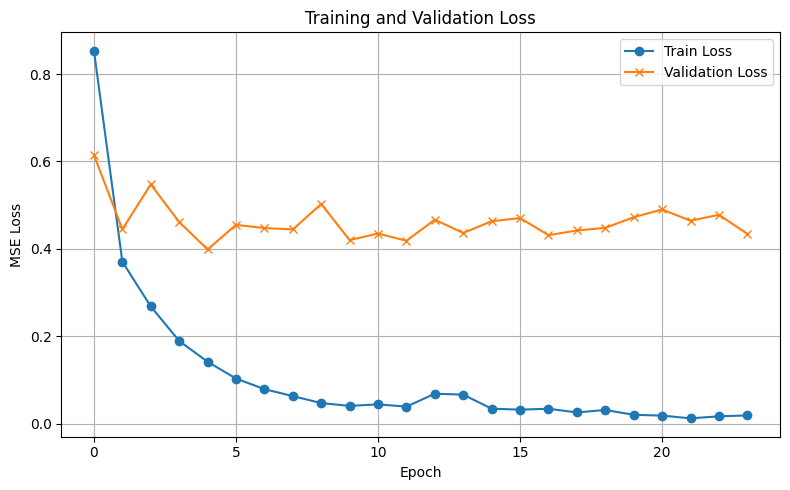

In [ ]:
plot_losses(train_losses, val_losses)

In [204]:
#load saved model 
model = MOSPredictor().to(device)
model.load_state_dict(torch.load("/home/lovish/PROJECTS/RealnessProject/Experiments/FinalModel/Model3.pth"))
model.eval()

#find the spearman correlation on the test set
spearman_corr, pearson_corr = evaluate_spearman(model, test_loader, device)
print(f"Spearman Correlation: {spearman_corr:.4f}")
print(f"Pearson Correlation: {pearson_corr:.4f}")

/home/lovish/PROJECTS/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Spearman Correlation: 0.7778
Pearson Correlation: 0.7976
